In [203]:
# Import libraries
import os
import random
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Layer, Input, Lambda, Activation
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model

In [204]:
# Extract data
data = pd.read_csv('../../ETL/Load/stockData.csv', header=(0), sep=';')

In [205]:
data

,TICKER,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
0,ABEV3,2014-07-01,21.706832,2.906275,0.258062,0.634963,0.029252,5.601715,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.376079,0
1,ABEV3,2014-08-01,22.676506,2.906275,0.258062,0.634963,0.028001,5.851952,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.278858,0
2,ABEV3,2014-09-01,22.219375,2.906275,0.258062,0.634963,0.028577,5.733983,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.327730,0
3,ABEV3,2014-10-01,22.718062,2.906275,0.258062,0.634963,0.027950,5.862676,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.286358,0
4,ABEV3,2014-11-01,23.216752,2.906275,0.258062,0.634963,0.027349,5.991369,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.211723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,YDUQ3,2023-08-01,-102.086973,10.561267,-0.018731,-0.677386,0.006635,1.912161,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.501691,0
11359,YDUQ3,2023-09-01,-99.581156,10.561267,-0.018731,-0.677386,0.006802,1.865226,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.529218,0
11360,YDUQ3,2023-10-01,-88.856255,10.561267,-0.018731,-0.677386,0.007623,1.664341,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.390872,0
11361,YDUQ3,2023-11-01,-100.683712,10.561267,-0.018731,-0.677386,0.006728,1.885877,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.531334,0


In [206]:
# Describe original data
data.describe()

,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
count,11363.000000,11363.000000,11363.000000,11363.000000,11363.000000,11363.000000,1.136300e+04,1.136300e+04,1.136300e+04,1.136300e+04,11363.000000,11363.000000,11363.000000
mean,-531.551791,33.890718,-0.025214,0.338965,4.741799,51.896740,1.533774e+10,1.978991e+10,3.818294e+09,inf,3.918511,0.163647,0.097333
std,15684.407655,508.396423,3.095612,2.592203,78.270801,1018.558948,2.748858e+10,6.773164e+10,2.313760e+10,NaN,91.344843,0.630312,0.296424
min,-765054.927367,-664.507625,-63.574215,-66.250000,-0.000000,-1249.308423,6.943000e+06,0.000000e+00,4.469333e+04,7.070553e-02,-111.585170,-0.995833,0.000000
25%,2.251269,5.016680,0.036619,0.000000,0.003078,0.682970,1.824915e+09,1.206523e+09,2.530056e+08,1.164050e+00,0.170000,-0.176193,0.000000
50%,8.823358,9.895760,0.120799,0.282966,0.022017,1.575433,5.417423e+09,3.935138e+09,7.231214e+08,1.629700e+00,0.920250,0.069011,0.000000
75%,23.070468,17.793117,0.197393,0.594902,0.058745,3.689210,1.594072e+10,1.333942e+10,1.821185e+09,2.419938e+00,2.175100,0.362940,0.000000
max,12635.786682,14885.774638,11.746541,45.098061,2196.206875,38484.339615,2.149780e+11,7.532630e+11,4.176953e+11,inf,2770.000000,10.778047,1.000000


In [207]:
# Separate train and test data
# Train: first 8 years
# Test: last 2 years

cutoff_year = 2021

data['DATE'] = pd.to_datetime(data['DATE'])
data_train = data[data['DATE'].dt.year <= cutoff_year]
data_test = data[data['DATE'].dt.year > cutoff_year]

In [208]:
data_train = data[data['DATE'].dt.year <= cutoff_year]
data_test = data[data['DATE'].dt.year > cutoff_year]

In [209]:
# Function to remove outliers using std
def remove_outliers_std(data_train, data_test, column, factor = 3):
    data_std = data_train[column].std()
    data_mean = data_train[column].mean()
    lower_bound = data_mean - factor * data_std
    upper_bound = data_mean + factor * data_std
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

# Function to remove outliers using IQR
def remove_outliers_iqr(data_train, data_test, column, factor = 1.5):
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

In [210]:
# List of features and the class column
features = data.columns.tolist()[2:-1]
binary_class = data.columns.tolist()[-1]

# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)

# Clean outliers from data
method = 'iqr' # std or iqr
factor = 9

if method == 'std':
    for feature in features:
        data_train, data_test = remove_outliers_std(data_train, data_test, feature, factor)
elif method == 'iqr':
    for feature in features:
        data_train, data_test = remove_outliers_iqr(data_train, data_test, feature, factor)

In [211]:
# Describe train data without outliers
data_train.describe()

,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
count,6946,6946.000000,6946.000000,6946.000000,6946.000000,6946.000000,6946.000000,6.946000e+03,6.946000e+03,6.946000e+03,6946.000000,6946.000000,6946.000000,6946.000000
mean,2017-12-11 20:00:45.608983296,18.200062,13.224227,0.110003,0.386042,0.041353,2.999542,1.078962e+10,9.001385e+09,1.396227e+09,1.993848,1.182637,0.215547,0.108696
min,2013-01-01 00:00:00,-192.478515,-19.123328,-1.284227,-3.785075,-0.000000,-12.734168,1.036100e+07,0.000000e+00,1.176395e+07,0.106487,-10.676650,-0.911268,0.000000
25%,2015-12-01 00:00:00,4.270227,6.104965,0.046290,0.021948,0.005221,0.792370,1.683371e+09,1.170289e+09,2.454349e+08,1.181579,0.307900,-0.129170,0.000000
50%,2018-02-01 00:00:00,12.287671,10.032682,0.117895,0.306961,0.021812,1.701086,4.542941e+09,3.507187e+09,6.527424e+08,1.668396,1.030000,0.102152,0.000000
75%,2020-01-01 00:00:00,25.496252,17.313870,0.190104,0.601134,0.052767,3.577262,1.180359e+10,1.141893e+10,1.529499e+09,2.403678,2.028070,0.404091,0.000000
max,2021-12-01 00:00:00,225.951033,82.780883,1.289349,5.366712,0.519884,28.662066,1.268052e+11,9.556346e+10,1.513876e+10,11.800608,16.848600,5.176469,1.000000
std,NaN,37.567360,11.875376,0.224803,0.650131,0.059949,3.824802,1.739369e+10,1.345199e+10,2.105936e+09,1.352733,2.721122,0.603904,0.311279


In [212]:
# Describe test data without outliers
data_test.describe()

,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
count,1971,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03,1.971000e+03,1971.000000,1971.000000,1971.000000,1971.000000
mean,2022-12-22 01:24:44.931506944,13.389470,11.690513,0.165403,0.350597,0.060575,2.329056,1.274913e+10,1.215343e+10,1.739781e+09,1.954233,1.711011,0.042395,0.049214
min,2022-01-01 00:00:00,-194.122537,-45.325658,-1.296702,-2.428702,-0.000000,-2.014198,6.943000e+06,0.000000e+00,1.176409e+07,0.070706,-14.397300,-0.995833,0.000000
25%,2022-07-01 00:00:00,3.360939,4.444562,0.074769,0.037331,0.006591,0.727043,2.593505e+09,1.844740e+09,3.940040e+08,1.252675,0.513040,-0.217106,0.000000
50%,2023-01-01 00:00:00,7.899785,8.727727,0.149563,0.268638,0.025984,1.457552,7.909456e+09,6.299577e+09,9.604146e+08,1.632498,1.260000,0.022572,0.000000
75%,2023-07-01 00:00:00,19.004422,15.899755,0.232561,0.563454,0.074986,2.955081,1.612153e+10,1.502056e+10,1.985006e+09,2.311305,2.378010,0.245303,0.000000
max,2023-12-01 00:00:00,223.998153,70.534504,1.289349,1.886858,0.512998,26.945149,1.268052e+11,9.251815e+10,1.432544e+10,11.800608,17.573050,2.515625,1.000000
std,NaN,29.914105,13.423397,0.263096,0.494855,0.089168,2.676575,1.630421e+10,1.628682e+10,2.307761e+09,1.372577,3.101552,0.424049,0.216369


In [213]:
# Change data to numpy
data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

# Get number of rows and columns
ncol = data.shape[1]

# Get arrays for features and class
y_train = data_train[:,-1]
X_train = data_train[:,2:ncol-2]
y_test = data_test[:,-1]
X_test = data_test[:,2:ncol-2]

In [214]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [215]:
# Subtractive Clustering:
def subtractive_clustering(X, number_of_rules, radius=0.2):
    # Compute pairwise distances between points
    d = pdist(X, 'euclidean')
    d_squareform = squareform(d) # Distance matrix between points
    # Calculate potential for each point
    potential = np.sum(np.exp(-d_squareform**2 / (radius/2**2)), axis=1)
    # Sort by potential and select highest point
    idx = np.argsort(potential)[::-1][0]
    # Start rule center with highest potential point as a cluster center
    rule_centers = X[idx]
    # If number of rules is larger than 1, continue algorithym for the following cluster centers
    if number_of_rules > 1:
        for i in range(number_of_rules-1):
            potential_star = potential[idx]
            X_star = X[idx]
            distances = np.sqrt(np.sum((X - X_star) ** 2, axis=1))
            potential = potential - potential_star*np.exp(-distances**2 / (radius/2**2))
            X_star = X[idx]
            idx = np.argsort(potential)[::-1][0]
            rule_centers = np.vstack((rule_centers, X[idx]))
    return rule_centers.T

In [216]:
# Get Rule Centers (means of gaussian membership functions)

# Define dataset dimensions
input_dim = 11
num_rules = 2

# Apply clustering to get rule centers
rule_centers = subtractive_clustering(X_train, num_rules, radius=0.2)
print("Rule Centers:", rule_centers)

Rule Centers: [[-0.36064675 -0.19256755]
 [ 0.32625299 -0.22929349]
 [ 0.4030558   0.03510853]
 [-0.17147151 -0.15187825]
 [ 0.29465849 -0.25279527]
 [-0.54025816 -0.44624307]
 [ 3.52464293 -0.22826024]
 [-0.66919692 -0.50194938]
 [ 1.86198858 -0.43468593]
 [ 1.28094224  0.17872032]
 [ 0.82595508  0.02037266]]


In [217]:
# Convert y to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [218]:
# Upsample 1 Class
# Convert X_train and y_train to DataFrame and Series, respectively
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Split the dataset by class
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Resample minority class to match the majority class size
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     
                                      n_samples=len(X_train_majority),  
                                      random_state=42)

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,     
                                      n_samples=len(y_train_majority),  
                                      random_state=42)

# Combine majority class and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [219]:
# Convert y to integer
y_train = y_train.astype(int)

In [220]:
class FuzzificationLayer(Layer):
    def __init__(self, num_rules, initial_means, **kwargs):
        super(FuzzificationLayer, self).__init__(**kwargs)
        self.num_rules = num_rules
        self.initial_means = tf.constant(initial_means, dtype=tf.float32)  # Initial means

    def build(self, input_shape):
        num_features = input_shape[-1]

        # Ensure means match the dimensions
        assert self.initial_means.shape == (input_dim, self.num_rules), \
    f"Expected shape {(input_dim, self.num_rules)}, but got {self.initial_means.shape}"
        
        # Trainable parameters for Gaussian membership functions
        self.means = self.add_weight(
            shape=(num_features, self.num_rules),
            initializer=tf.keras.initializers.Constant(self.initial_means), # Initialize with rule centers
            trainable=True,
            name='means'
        )
        self.stds = self.add_weight(
            shape=(num_features, self.num_rules),
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True,
            name='stds'
        )

    def call(self, inputs):
        # Expand dimensions for broadcasting
        inputs_expanded = tf.expand_dims(inputs, axis=-1)  # (batch_size, num_features, 1)
        # Gaussian membership functions
        membership_values = tf.exp(
            -((inputs_expanded - self.means) ** 2) / (2 * (self.stds ** 2))
        )
        return membership_values


class RuleLayer(Layer):
    def call(self, inputs):
        # Multiply membership values across features for each rule
        # Inputs: (batch_size, num_features, num_rules)
        rule_strengths = tf.reduce_prod(inputs, axis=1)  # (batch_size, num_rules)
        return rule_strengths


class NormalizationLayer(Layer):
    def call(self, inputs):
        # Normalize rule strengths
        # Inputs: (batch_size, num_rules)
        normalized_weights = inputs / tf.reduce_sum(inputs, axis=1, keepdims=True)
        return normalized_weights


class WeightedCombinationLayer(Layer):
    def __init__(self, input_dim, num_rules, **kwargs):
        super(WeightedCombinationLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.num_rules = num_rules

    def build(self, input_shape):
        # Initialize weights for each rule and input dimension
        self.rule_weights = self.add_weight(
            shape=(self.input_dim, self.num_rules),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
            name="rule_weights"
        )
        # Initialize biases for each rule
        self.biases = self.add_weight(
            shape=(self.num_rules,),
            initializer="zeros",
            trainable=True,
            name="biases"
        )

    def call(self, inputs):
        normalized_weights, original_inputs = inputs  # [batch_size, num_rules], [batch_size, input_dim]
        
        # 1. Dot product of the original inputs with the rule weights
        dot_product = tf.matmul(original_inputs, self.rule_weights)  # Shape: [batch_size, 2]

        # 2. Add the biases
        dot_product_with_bias = dot_product + self.biases  # Shape: [batch_size, 2]

        # 3. Multiply everything by the normalized weights
        # To broadcast correctly, expand normalized_weights to match the shape
        normalized_weights_expanded = tf.expand_dims(normalized_weights, axis=-1)  # Shape: [batch_size, num_rules, 1]

        # Sum over the rules dimension after scaling
        output = normalized_weights * dot_product_with_bias  # Element-wise multiplication, shape: [batch_size, num_rules]
        
        return output  # Final shape: [batch_size, 2]

def build_anfis_model(input_dim, num_rules):
    # Input layer
    inputs = Input(shape=(input_dim,), name='InputLayer')

    # Layer 1: Fuzzification
    fuzzification = FuzzificationLayer(num_rules=num_rules, initial_means=rule_centers, name='FuzzificationLayer')(inputs)

    # Layer 2: Rule Strengths
    rule_strengths = RuleLayer(name='RuleLayer')(fuzzification)

    # Layer 3: Normalize Rule Strengths
    normalized_weights = NormalizationLayer(name='NormalizationLayer')(rule_strengths)

    # Layer 4: Weighted Combination
    weighted_combination = WeightedCombinationLayer(input_dim, num_rules, name='WeightedCombinationLayer')(
        [normalized_weights, inputs]
    )

    # Layer 5: Defuzzification
    outputs = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), name="OutputLayerSum")(weighted_combination)
    #outputs_sum = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), name="OutputLayerSum")(weighted_combination)
    #outputs = Activation('sigmoid', name='OutputLayer')(outputs_sum)
    
    

    # Build model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [221]:
# Build model
anfis_model = build_anfis_model(input_dim, num_rules)

# Compile the model
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
anfis_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

anfis_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)       │ (None, 11)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FuzzificationLayer            │ (None, 11, 2)             │              44 │ InputLayer[0][0]           │
│ (FuzzificationLayer)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ RuleLayer (RuleLayer)         │ (None, 2)                 │               0 │ FuzzificationLayer[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NormalizationLayer            │ (None, 2)                 │               0 │ RuleLayer[0][0]            │
│ (NormalizationLayer)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ WeightedCombinationLayer      │ (None, 2)                 │              24 │ NormalizationLayer[0][0],  │
│ (WeightedCombinationLayer)    │                           │                 │ InputLayer[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OutputLayerSum (Lambda)       │ (None, 1)                 │               0 │ WeightedCombinationLayer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 68 (272.00 B)

 Trainable params: 68 (272.00 B)

 Non-trainable params: 0 (0.00 B)

In [222]:
loss, mse = anfis_model.evaluate(X_train_balanced, y_train_balanced, verbose=1)

387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.5605 - loss: 2.1237


In [223]:
# Train the model
histAnfis = anfis_model.fit(X_train_balanced[:], y_train_balanced[:],  epochs=100, verbose=2)

Epoch 1/100
387/387 - 1s - 2ms/step - accuracy: 0.5812 - loss: 0.2793
Epoch 2/100
387/387 - 0s - 531us/step - accuracy: 0.5933 - loss: 0.2412
Epoch 3/100
387/387 - 0s - 529us/step - accuracy: 0.5926 - loss: 0.2412
Epoch 4/100
387/387 - 0s - 527us/step - accuracy: 0.5882 - loss: 0.2418
Epoch 5/100
387/387 - 0s - 527us/step - accuracy: 0.5871 - loss: 0.2420
Epoch 6/100
387/387 - 0s - 528us/step - accuracy: 0.5934 - loss: 0.2403
Epoch 7/100
387/387 - 0s - 534us/step - accuracy: 0.5891 - loss: 0.2408
Epoch 8/100
387/387 - 0s - 542us/step - accuracy: 0.5948 - loss: 0.2410
Epoch 9/100
387/387 - 0s - 539us/step - accuracy: 0.5906 - loss: 0.2410
Epoch 10/100
387/387 - 0s - 542us/step - accuracy: 0.5933 - loss: 0.2407
Epoch 11/100
387/387 - 0s - 547us/step - accuracy: 0.5931 - loss: 0.2403
Epoch 12/100
387/387 - 0s - 551us/step - accuracy: 0.5987 - loss: 0.2411
Epoch 13/100
387/387 - 0s - 561us/step - accuracy: 0.5952 - loss: 0.2408
Epoch 14/100
387/387 - 0s - 609us/step - accuracy: 0.5901 - lo

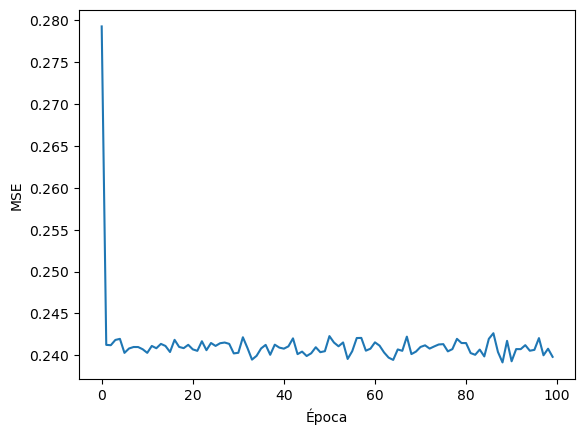

In [224]:
plt.plot(histAnfis.history['loss'])
plt.xlabel('Época')
plt.ylabel('MSE')
output_dir = 'Graphs'
plt.savefig(os.path.join(output_dir, f'loss_anfis.png'))

In [225]:
# Scale the test data
X_test = scaler.transform(X_test)

In [226]:
# Run model prediction
y_pred = anfis_model.predict(X_test)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


In [227]:
# Get Asset Appreciation per Cuttof Point
cutoff_points = np.linspace(min(y_pred), max(y_pred), 100)

average_appreciation = []
class1_count = []

# For each cutoff point, get number of assets and average appreciation
for cutoff in cutoff_points:
    y_pred_appreciation = y_pred.copy()
    # Treat predicted array
    y_pred_appreciation[np.isnan(y_pred_appreciation)] = 0
    y_pred_appreciation[y_pred>=cutoff] = 1
    y_pred_appreciation[y_pred<cutoff] = 0
    y_pred_appreciation = np.sign(y_pred_appreciation.flatten())
    y_pred_appreciation.astype(int)

    # Add to list the number of class 1 assets
    class1_count.append(sum(y_pred_appreciation))
    data_test_period = np.array([row for row in data_test[y_pred_appreciation==1]])
    # Add the average appreciation of the assets to list if there are any
    if len(data_test_period):
        average_appreciation.append(np.mean(data_test_period[:,-2]))
    else:
        average_appreciation.append(0.0)
    

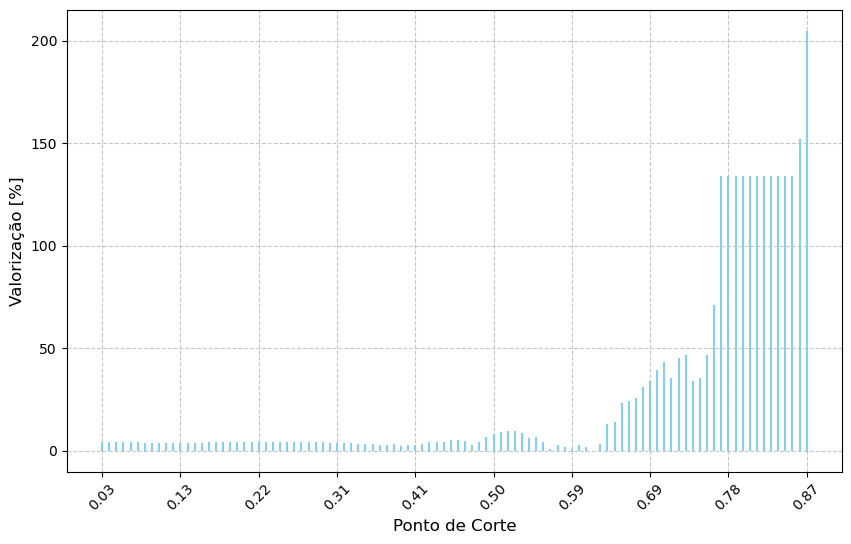

In [228]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.stem(cutoff_points, [x * 100 for x in average_appreciation], linefmt='skyblue', markerfmt=' ', basefmt=" ")

# Adding labels and title
plt.xlabel('Ponto de Corte', fontsize=12)
plt.ylabel('Valorização [%]', fontsize=12)

# Determine 10 equally spaced indices for the x-axis
indices = np.linspace(0, len(cutoff_points) - 1, 10, dtype=int)
spaced_cutoff_points = np.squeeze(cutoff_points[indices])
spaced_labels = [f"{float(x):.2f}" for x in spaced_cutoff_points]

# Optional: Add grid and customize ticks
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(spaced_cutoff_points, spaced_labels, rotation=45)
plt.yticks(fontsize=10)

# Show the plot
plt.savefig(os.path.join(output_dir, f'appreciationXcutoff_anfis.png'))
plt.show()

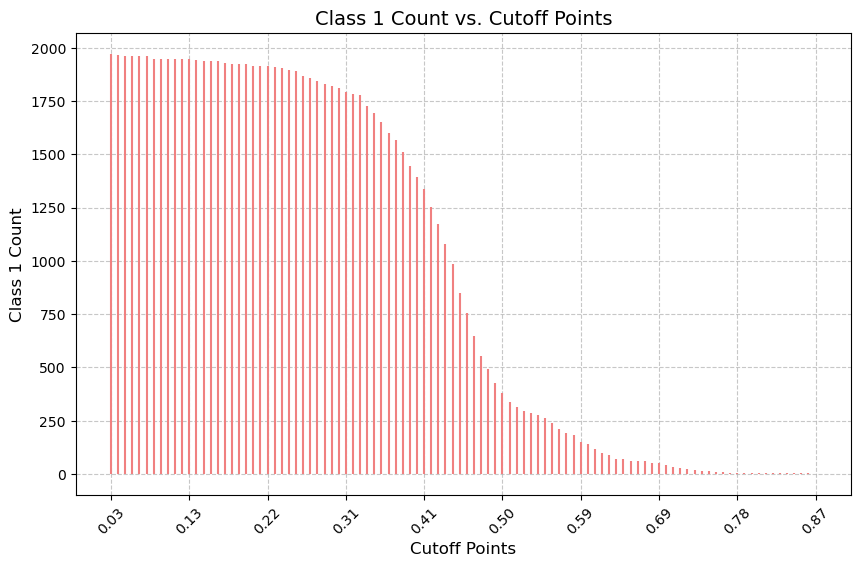

In [229]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.stem(cutoff_points, class1_count, linefmt='lightcoral', markerfmt=' ', basefmt=" ")

# Adding labels and title
plt.xlabel('Cutoff Points', fontsize=12)
plt.ylabel('Class 1 Count', fontsize=12)
plt.title('Class 1 Count vs. Cutoff Points', fontsize=14)

# Determine 10 equally spaced indices for the x-axis
indices = np.linspace(0, len(cutoff_points) - 1, 10, dtype=int)
spaced_cutoff_points = np.squeeze(cutoff_points[indices])
spaced_labels = [f"{x:.2f}" for x in spaced_cutoff_points]

# Optional: Add grid and customize ticks
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(spaced_cutoff_points, spaced_labels, rotation=45)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [230]:
# Get ideal cutoff point
# Generate cutoff points
cutoff_points = np.linspace(min(y_pred), max(y_pred), 100)

# Initialize lists to store rates
true_positive_rates = []
true_negative_rates = []

# Calculate rates for each cutoff
for cutoff in cutoff_points:
    # Classify predictions based on the cutoff
    y_pred_classes = np.where(y_pred.flatten() >= cutoff, 1, 0)
    
    # Compute true positives and true negatives
    true_positives = np.sum((y_pred_classes == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred_classes == 0) & (y_test == 0))
    
    # Total positives and negatives in the true labels
    total_positives = np.sum(y_test == 1)
    total_negatives = np.sum(y_test == 0)
    
    # True positive rate (TPR) and true negative rate (TNR)
    tpr = true_positives / total_positives if total_positives > 0 else 0
    tnr = true_negatives / total_negatives if total_negatives > 0 else 0
    
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Find the cutoff where the two curves cross
# This happens when |TPR - TNR| is minimized
tpr_array = np.array(true_positive_rates)
tnr_array = np.array(true_negative_rates)
cutoff_cross = cutoff_points[np.argmin(np.abs(tpr_array - tnr_array))]

In [231]:
round(cutoff_cross[0],3)

0.456

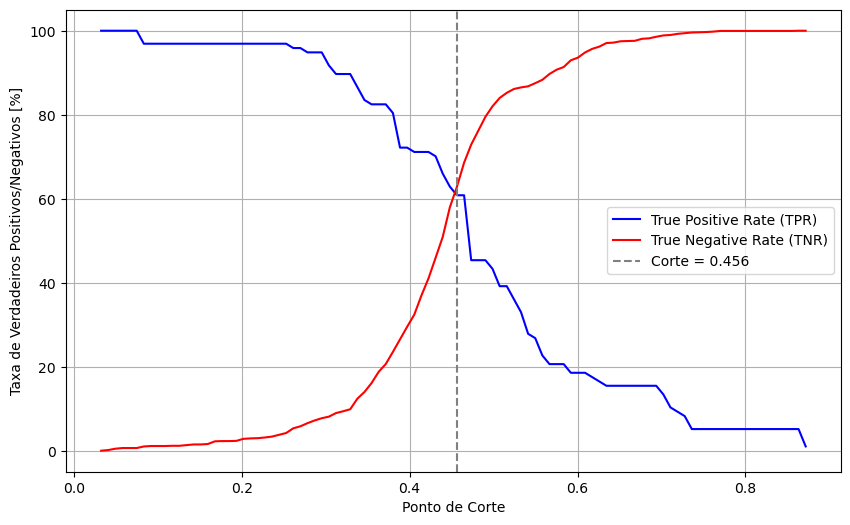

In [232]:
# Plot the TPR and TNR
plt.figure(figsize=(10, 6))
plt.plot(cutoff_points, [x * 100 for x in true_positive_rates], label='True Positive Rate (TPR)', color='blue')
plt.plot(cutoff_points, [x * 100 for x in true_negative_rates], label='True Negative Rate (TNR)', color='red')
plt.axvline(cutoff_cross, color='gray', linestyle='--', label=f'Corte = {cutoff_cross[0]:.3f}')
plt.xlabel('Ponto de Corte')
plt.ylabel('Taxa de Verdadeiros Positivos/Negativos [%]')
plt.legend()
plt.grid()

# Save
plt.savefig(os.path.join(output_dir, f'trueRateXcutoff_anfis.png'))

plt.show()

In [233]:
# Save PRedicted Signals for future use
y_pred_signal = y_pred.copy()

# Treat predicted array
y_pred[y_pred>=cutoff_cross] = 1
y_pred[y_pred<cutoff_cross] = 0
y_pred = np.sign(y_pred.flatten())
y_pred.astype(int)

array([1, 1, 1, ..., 1, 0, 0])

In [234]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

Accuracy: 0.6276002029426687
Precision: 0.0781456953642384
Recall (Sensitivity): 0.6082474226804123
F1-Score: 0.13849765258215962


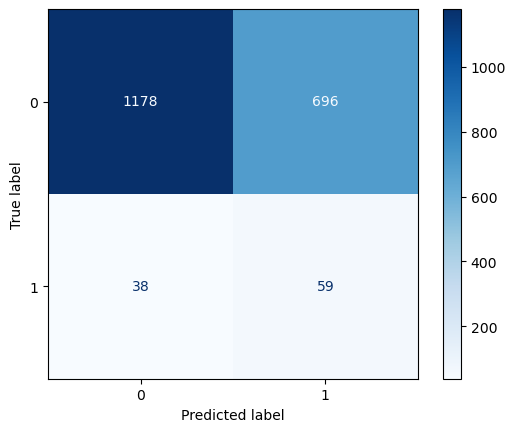

In [235]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)

# Save
plt.savefig(os.path.join(output_dir, f'confusionMatrix_anfis.png'))

plt.show()

In [236]:
# Append results to data_test and save
data_test = pd.DataFrame(data_test, columns=data.columns)

data_test['SIGNAL'] = y_pred_signal
data_test['CLASS_PRED'] = y_pred.astype(int)

# Save results
data_test.to_csv("anfis_test_results.csv", sep=';', decimal='.', encoding='ISO-8859-1', index=False)